# Imports

In [10]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
import math
import matplotlib.pyplot as plt

# Ein Gedicht

### Quantum meets machine,
### New way to learn and glean,
### Speed and power untold,
### The future to unfold.
~ ChatGPT4

# Die Basics

Parametrisierte Quantum Schaltungen (PQC), bei denen die Gates durch veränderbare Parameter definiert sind, sind die Grundbausteine von QML. <br>
##### Beispiel
Einfacher PQC, mit zwei parametrisierten Gates, ein single-qubit z-Rotations Gate mit variablen Winkel $\theta$ und ein two-qubit z-Rotations Gate auch mit der Winkelvariable $\theta$.<br>
In Qiskit sieht das wie folgt aus:

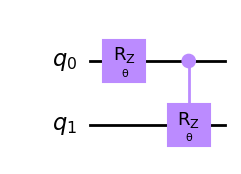

In [3]:
theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.rz(theta, 0)
qc.crz(theta, 0, 1)
qc.draw(output="mpl")

Oder auch mit zwei verschiedenen Parametern:

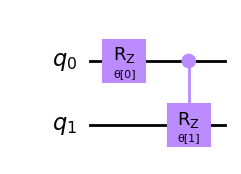

In [6]:
from qiskit.circuit import ParameterVector
theta_list = ParameterVector('θ', length=2)

qc = QuantumCircuit(2)
qc.rz(theta_list[0], 0)
qc.crz(theta_list[1], 0, 1)
qc.draw(output="mpl")

### Die Qiskit Single-Quibit Gates

##### X-Gate
<br>
Vertauscht die Amplitudes der $|0\rangle$ und $|1\rangle$ Zustände: <br>
$X|0\rangle = \begin{bmatrix}
0 & 1\\
1 & 0 
\end{bmatrix} \begin{bmatrix}
1\\
0
\end{bmatrix}
= \begin{bmatrix}0\\1\end{bmatrix} = |1\rangle
$

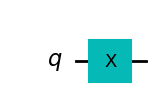

In [3]:
qc = QuantumCircuit(1)
qc.x(0)
qc.draw(output="mpl")

##### Y- und Z-Gates

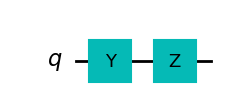

In [6]:
qc = QuantumCircuit(1)

qc.y(0) # Do Y-gate on qubit 0
qc.z(0) # Do Z-gate on qubit 0
qc.draw(output="mpl")

##### Hadamard Gate
<br>
$H = \frac{1}{\sqrt{2}} \begin{bmatrix}
1 & 1\\
1 & -1 
\end{bmatrix}$

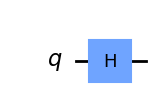

In [7]:
qc = QuantumCircuit(1)
qc.h(0)
qc.draw(output="mpl")

#### P-Gate
<br>
$P(\phi) = \begin{bmatrix}
1 & 0\\
0 & \exp{(i \phi)} 
\end{bmatrix}$

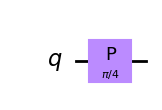

In [9]:
qc = QuantumCircuit(1)
qc.p(math.pi/4, 0)
qc.draw(output="mpl")

#### U-Gate

Das allgemeinste Gate, mit dem man eigentlich fast alle anderen Gates erstellen kann.
<br>
<br>
$U(\theta , \phi , \lambda)=\begin{bmatrix}
cos(\frac{\theta}{2}) & -\exp{(i \lambda)}sin(\frac{\theta}{2})\\
\exp{(i \phi)}sin(\frac{\theta}{2}) & \exp{(i (\phi + \lambda))}cos(\frac{\theta}{2}) 
\end{bmatrix}$

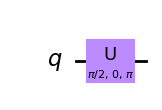

In [11]:
# Let's have U-gate transform a |0> to |+> state
qc = QuantumCircuit(1)
qc.u(math.pi/2, 0, math.pi, 0)
qc.draw(output="mpl")

### Wie wählen wir den richtigen PQC aus?

- Um PQCs als Machine Learning Model zu nutzen, müssen sie gut verallgemeinern können.
Das bedeutet, dass der Schaltkreis in der Lage sein sollte, eine signifikante Teilmenge der Zustände innerhalb des Hilbert-Raums der Ausgabe zu erzeugen.<br>
- Der PQC sollte die verwendeten Qubits zudem entanglen, um einfaches simulieren auf klassischen Computern zu verhindern. 
- Hardware Effizienz

### Expressibility/Aussagekraft

Die Aussagekraft eines PQC ist im Wesentlichen die Abdeckung des Hilbert-Raums durch den Hypothesenraum des PQC.<br>
<br>
##### Beispiel
Wir vergleichen zwei 1-Quibit Schaltungen.

Schaltung A: <br>
Ein Single-Qubit Hadamard Gate gefolt von einem z-Rotations Gate.

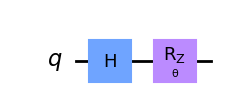

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Schaltung erstellen
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Schaltung A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)


qc_A.draw(output="mpl")

Schaltung B: <br>
Ein Single-Qubit Hadamard Gate gefolt von einem z- und einem x-Rotations Gate.

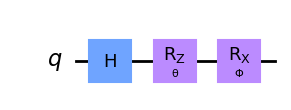

In [5]:
# Schaltung B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)

qc_B.draw(output="mpl")

- zufällig verteilte Parameter für die Gates
- Zustandsvektoren für Schaltung A & B werden auf der Bloch Kugel abgebildet

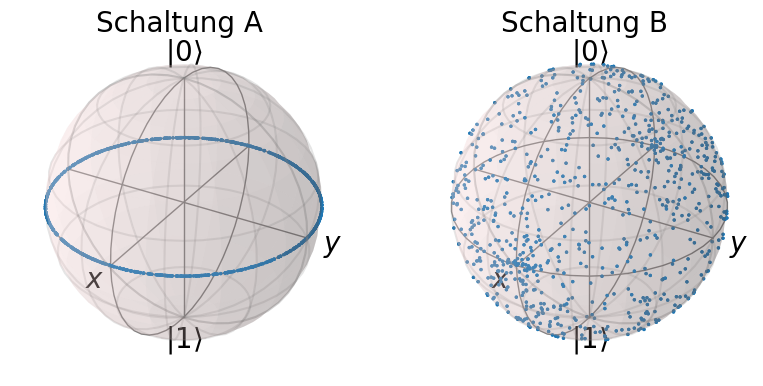

In [7]:
# Der Parameterraum für die beiden Parameter theta und pi wird einheitlich abgetastet
np.random.seed(0)
num_param = 800
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

# Die Werteliste werden als Zustandsvektoren auf der Bloch Kugel gezeichnet
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

def state_to_bloch(state_vec):
    # Converts state vectors to points on the Bloch sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

def draw_to_bloch(state_vec):
    # Zustandsvektoren zu Punkte auf Bloch Sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch Plotting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Zustandsvektoren für A und B für die 800 Parameter bilden und zur Bloch Kugel hinzufügen
for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))


b1.show(title="Schaltung A")
b2.show(title="Schaltung B")

#### Bloch-Kugel

- Grafisch-geometrische Darstellung in der Quantenmechanik
- Überlangerung der Zustände eines Quibits als Punkt auf der Kugel 

#### Resultat

A: Zustände nur auf dem Äquator der Bloch-Kugel.<br>
B: Wegen zusätzlichem Rotations-Gate kann ganze Kugel abgedeckt werden.
-> Schaltung B größere Aussagekraft als Schaltung A
<br>
#### -> Eine 1-Qubit Schaltung hat eine gute Aussagekraft falls sie die "ganze" Bloch Sphere erkunden kann. 

#### Aussagekraft messen

Ein Quantum Circuit $U(\mathbf{x})$, und die Menge
$$f(\mathbf{x},\mathbf{y}) = |\langle 0 | U^{\dagger}(\mathbf{y})U(\mathbf{x})|0\rangle|^{2}$$
Diese Menge ist die Güte der beiden Zustände: 
$$\begin{align*}
|\psi_{\mathbf{x}}\rangle = U(\mathbf{x})|0\rangle~~&\text{and}~~|\psi_{\mathbf{y}}\rangle = U(\mathbf{y})|0\rangle:\\
|\langle \psi_{\mathbf{y}}|\psi_{\mathbf{x}}\rangle|^{2} &= |\langle 0 |U^{\dagger}(\mathbf{y})U(\mathbf{x})|0\rangle|^{2}.
\end{align*}$$

Wir generieren ein paar zufällige Realisierungen von $\mathbf{x},\mathbf{y}$. Das gibt uns eine Menge von zufällig generierten $f$; sodass $F = \{f_{1}, f_{2}, \cdots \}$.

Um die Aussagekraft zu berechnen, müssen wir zwei Sachen machen:
* Ein Histogramm von den Werten in $F$. Die Ausgabe von dem Histogram sieht wie folgt aus: $B = \{(l_1, u_1), (l_2, u_2), \cdots \}$ wobei $l_{j}$ ($u_j$) die untere (obere) Grenze der Teilmenge $j$ ist. Es ergibt sich auch eine empirische Wahrscheinlichkeitsverteilungsfunktion $\mathrm{Pr}_{\text{emp}}(j)$, die einfach aussagt, wie wahrscheinlich es ist, dass ein Wert $f$ in der Teilmenge $j$ drin ist.
* Bei gegebenen Teilmenge vom Histogramm, müssen wir die Wahrscheinlichkeit berechnen, dass eine gegebene Güte in die Teilmenge $j$ fällt, falls die Schaltung, die diese Güte erzeugt, aus einer Haar-Zufallsverteilung gezogen wird. Falls die Schaltung n-Qubits besitzt, ist die Wahrscheinlichkeit einer Güte $f$:
$$ \mathrm{Pr}_{\text{Haar}}(f) = (N -1)*(1-f)^{N-2}~~N=2^{n}.$$
Um die Wahrscheinlichkeit über eine Teilmenge des Histogramms zu berechnen, benutzen wir ein Integral:
$$\mathrm{Pr}_{\text{Haar}}(j) = \int_{l_{j}}^{u_{j}}  \mathrm{Pr}_{\text{Haar}}(f) ~df =  (1-l_{j})^{N-1}  - (1-u_{j})^{N-1}$$
Die Aussagekraft wird dann als KL-Divergenz zwischen der empirisch beobachteten Wahrscheinlichkeitsverteilung (d. h. dem Histogramm) und der Wahrscheinlichkeitsverteilung geschätzt, die sich bei einer Haar-Zufallsverteilung ergeben würde.
$$\text{Expr} = \mathrm{KL}(\mathrm{Pr}_{\text{emp}}|| \mathrm{Pr}_{\text{Haar}}) = \sum_{j} \mathrm{Pr}_{\text{emp}}(j)\log\left(\frac{\mathrm{Pr}_{\text{emp}}(j)}{\mathrm{Pr}_{\text{Haar}}(j)}\right)$$

##### Haar-Zufallsverteilung

Ein Quantum Grundzustand kann als $ |\psi\rangle = \sum_{j=1}^{n} (c_{1j}+ic_{2j})|j\rangle$ beschrieben werden.<br>
Wobei $|j\rangle$ den j-te Orthonomalbasis-Vektor im n-dimensionalen Hilbertraum beschreibt. <br>
$c_{1j}~und~c_{2j}$ sind reelle Zahlen, beschränkt durch die Normalisierungsbedingung $\langle \psi | \psi\rangle = 1$.<br>
Die Haar Verteilung wird dann erreicht, falls man $c_{ij}$ unabhängig voneinander aus einer Gauß-Verteilung mit verschwindendem Mittelwert und endlicher Varianz bestimmt. 

<div>
<img src="images/haar.png" width="300"/>
</div>

n = 3. a) ist Haar-verteilt in einem 3-dim. Hilbertraum (Zustand ist nicht normalisiert).<br> b) (c's aus Gleichverteilung bestimmt) & c) (c's aus Cauchy-Lorentz-Verteilung bestimmt) nicht. 

##### Kullback-Leibler-Divergenz (KL-Divergenz)

Maß für die Unterschiedlichkeit zweier Wahrscheinlichkeitsverteilungen. Auch *relative Entropie* genannt.<br>
KL-Divergenz für Wahrscheinlichkeitsfunktionen P und Q diskreter Werte: <br>
$D(P||Q)=\sum_{x\epsilon X}P(x)*log\frac{P(x)}{Q(x)} = KL(P, Q)$ <br>
Bei Verteilungen für kontinuierliche Werte wird dann ein Integral verwendet.

### Entangling Fähigkeit

Entanglement ist ein sehr wichtiges Schlüsselkonzepzt in der Quanten Technik.
<br><br>
Eine Möglichkeit Entanglement zu messen ist die *Meyer-Wallach-Methode*, bei der das durschnittliche Entanglement zwischen zwei Qubits gemessen wird auf der Skala von 0-1. Sie wird häufig benutzt wegen ihrer guten Skalierbarkeit.

##### Meyer-Wallach-Messung
Die Messung kann nur auf Grundzustände von Multi-Qubit Schaltungen, $|\psi \rangle ~ \epsilon ~(\mathbb{C}^2)^{\otimes n}$, angewendet werden.<br>
Für alle j=1,...n und $b~\epsilon ~\{0, 1\}$ definieren wir die linear map $\iota_{j}(b): (\mathbb{C}^2)^{\otimes n}\to (\mathbb{C}^2)^{\otimes n-1}$ mit $\iota_j(b)|x_1\rangle \otimes ... \otimes |x_n\rangle = \delta_{b x_j} |x_1\rangle \otimes ... \otimes |x_{j-1}\rangle \otimes |x_{j+1}\rangle \otimes ...|x_{n}\rangle$
<br>
<br>
Meyer-Wallach-Messung:  $Q(\psi) \equiv \frac{4}{n}\sum_{j=1}^{n} D(\iota_{j}(0)|\psi\rangle, \iota_{j}(1)|\psi\rangle)$
<br>
<br>
mit generalisierten Distanz<br>
$D(|\psi\rangle, |\phi \rangle ) = \langle \psi | \psi\rangle\langle\phi|\phi\rangle - |\langle \psi| \phi\rangle|^2$
<br>
D ist dann sozusagen dass Quadrat der Fläche des Parallelograms, das von den Vektoren $|\psi\rangle $und $|\phi \rangle$ gebildet wird.

##### Beispiel
Zwei Schaltungen Multi-Qubit Schaltungen.

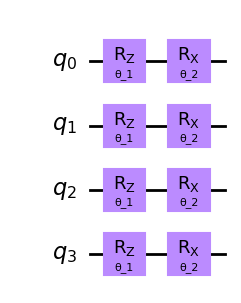

In [14]:
theta1 = Parameter('θ_1')
theta2 = Parameter('θ_2')

# Schaltung A

qc = QuantumCircuit(4)
qc.rz(theta1, 0)
qc.rz(theta1, 1)
qc.rz(theta1, 2)
qc.rz(theta1, 3)
qc.rx(theta2, 0)
qc.rx(theta2, 1)
qc.rx(theta2, 2)
qc.rx(theta2, 3)
qc.draw(output="mpl")

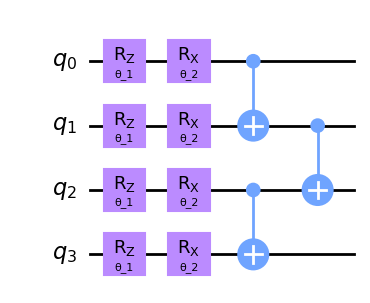

In [19]:
theta1 = Parameter('θ_1')
theta2 = Parameter('θ_2')

# Schaltung B

qc = QuantumCircuit(4)
qc.rz(theta1, 0)
qc.rz(theta1, 1)
qc.rz(theta1, 2)
qc.rz(theta1, 3)
qc.rx(theta2, 0)
qc.rx(theta2, 1)
qc.rx(theta2, 2)
qc.rx(theta2, 3)
qc.cx(0,1)
qc.cx(2,3)
qc.cx(1,2)

qc.draw(output="mpl")

A: Keine Entanglement -> Meyer-Wallach-Messung = 0.<br>
B: Mehrere Entanglements -> Meyer-Wallach-Messung > 0.

### Hardware Effizienz

- Qubit Anzahl
- Gate Anzahl
- Tiefe des Schaltkreises

### PQCs für Machine Learning

In QML werden PQCs typischerweise für zwei Sachen verwendet: <br>
- Für Data Encoding, bei dem die Gate Parameter durch die zu kodierenden Daten bestimmt werden. (kommt im nächsten Kapitel)
- Als Quantenmodell, bei dem die Parameter durch einen Optimierungsprozess bestimmt werden.

Klassisches Machine Learning
<div>
<img src="images/struct1.png" width="400"/>
</div>

Quantum Machine Learning
<div>
<img src="images/struct2.png" width="400"/>
</div>

#### ZZ-Feature-Map

Für Data Encoding

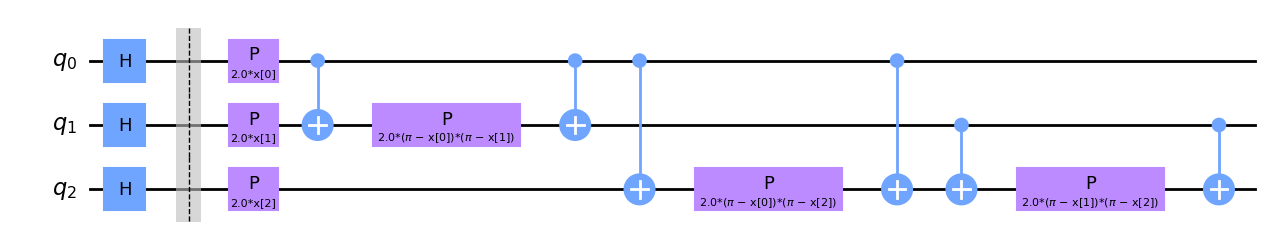

In [1]:
from qiskit.circuit.library import ZZFeatureMap
qc_zz = ZZFeatureMap(3, reps=1, insert_barriers=True)
qc_zz.decompose().draw(output="mpl")

#### Two-Local

Hardware effizienter PQC als Quantum Model.

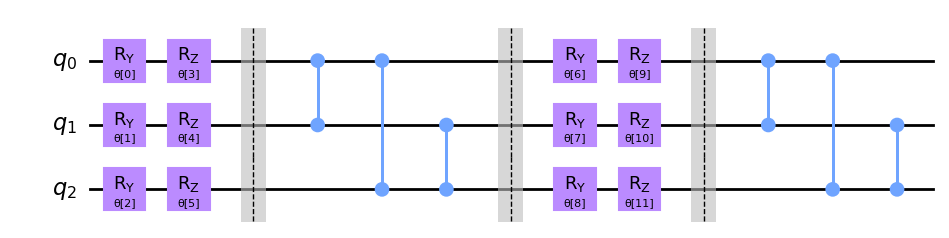

In [8]:
from qiskit.circuit.library import TwoLocal
qc_twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'],
                entanglement_blocks='cz', skip_final_rotation_layer=True,
                insert_barriers=True)

qc_twolocal.decompose().draw(output="mpl")

#### N-Local

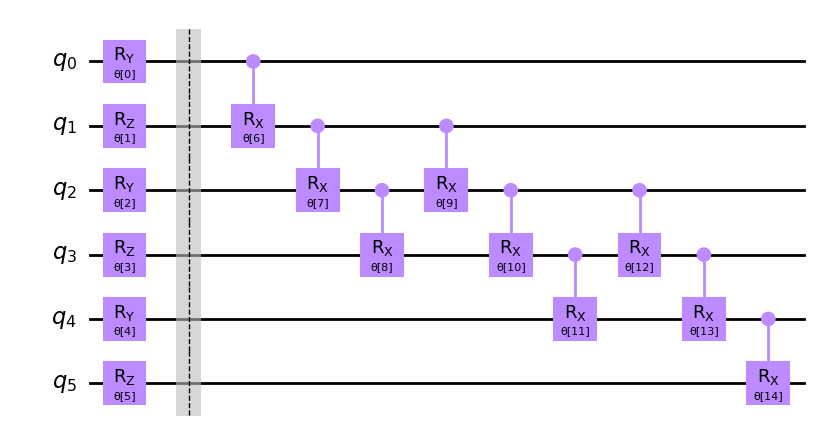

In [6]:
from qiskit.circuit.library import NLocal

# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4)
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

qc_nlocal = NLocal(num_qubits=6, rotation_blocks=rot,
                   entanglement_blocks=ent, entanglement='linear',
                   skip_final_rotation_layer=True, insert_barriers=True)

qc_nlocal.decompose().draw(output="mpl")

# Data Encoding

Bei klassischem Machine Learning werden die Daten numerisch dargestellt.<br>
Bei Quantum Machine Learning muss man schauen, wie man die Input Daten darstellt und effizient an ein Quantum Model übergibt.

##### Beispiel 
Dataset mit M Einträgen, die jeweils N Features haben.
<br>
$X = \{x^{(1)}, ..., x^{(m)}, ..., x^{(M)}\}$


## Basis Encoding

N-bit String zu einem N-qubit System umgewandelt. <br>
$x^{(m)} = (b_{1}, b_{2}, ..., b_{N})$ wird zu $|x^{m}\rangle = |b_{1}, b_{2}, ..., b_{N} \rangle$ mit $b_n \epsilon$ {0, 1} für n = 1, ..., N

$|X\rangle=\frac1{\sqrt{M}} \sum_{i=m}^{M} |x^{m}\rangle$

Beispiel: $x_1$ = 101 und $x_2$ = 111 wird zu Zustandsvektor $|X\rangle = \frac{1}{\sqrt{2}}*(|101\rangle + |111\rangle)$. (5 & 7) <br>
In Qiskit mit der *initialize* Funktion.

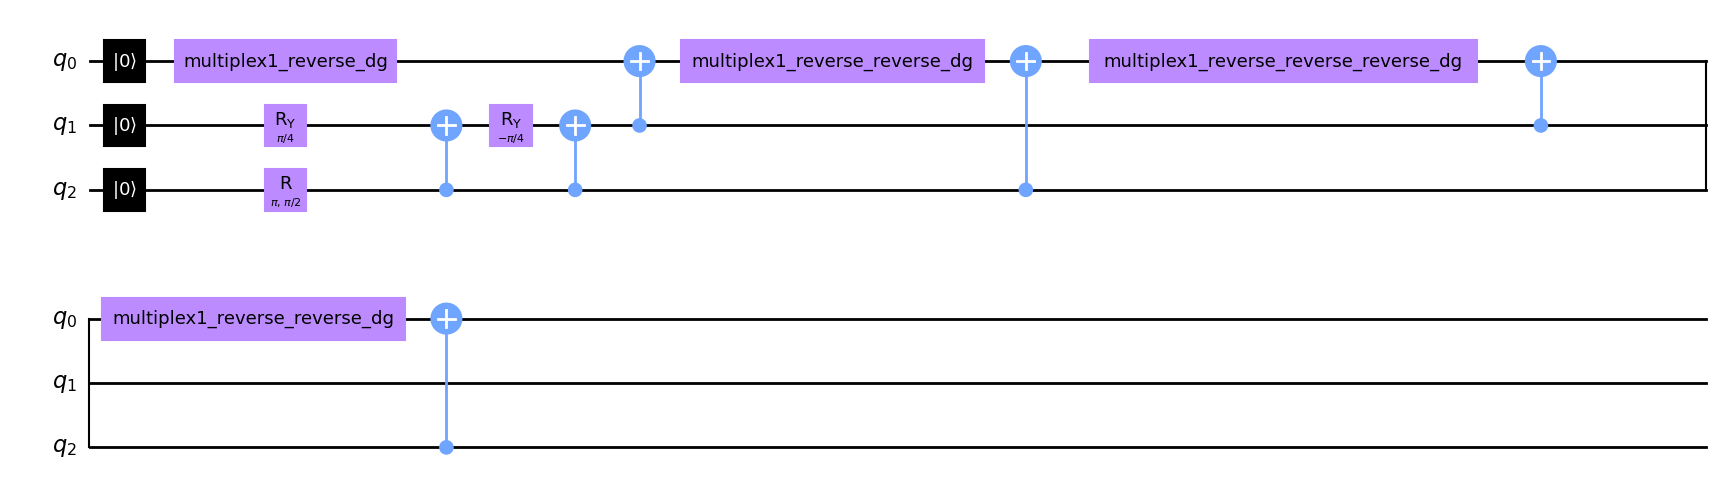

In [7]:
desired_state = [
    0,
    0,
    0,
    0,
    0,
    1 / math.sqrt(2),
    0,
    1 / math.sqrt(2)]

qc = QuantumCircuit(3)
qc.initialize(desired_state, [0,1,2])
qc.decompose().decompose().decompose().decompose().decompose().draw(output="mpl")

## Angle Encoding

Encodiert N Features zu Drehwinkel von n Qubits (N<=n).<br>
$|x\rangle$ = Tensorprodukt über $cos(x_i)|0\rangle+sin(x_i)|1\rangle$
<br>
<br>
Mit U-Gate bzw. Rotationsgate implementieren: <br>
$\lambda$ und $\phi$ sind beide null -> $U(x_{j}^{(i)}) = \begin{bmatrix}
cos(x_{j}^{(i)}) & -sin(x_{j}^{(i)})\\
sin(x_{j}^{(i)}) & cos(x_{j}^{(i)}) 
\end{bmatrix}$

<br><br>
$x = (0, \pi / 4, \pi / 2)$ -> 3 Features
<br><br>
$U(x_{j}^{(i)}) = RY(2x_{j}^{(i)})$<br><br>
Jeweils Single-Quibit Rotation um die Y-Achse mit dem Winkel $2x_j$

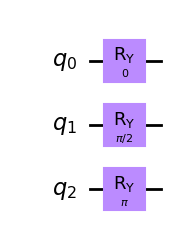

In [5]:
qc = QuantumCircuit(3)
qc.ry(0, 0)
qc.ry(2*math.pi/4, 1)
qc.ry(2*math.pi/2, 2)
qc.draw(output="mpl")

Anders als bei den ersten beiden Encodierungsmethoden wird hier nur ein Datanepunkt auf einmal encodiert und nicht das ganze Set.

## Amplitude Encoding

Die Daten werden auf die Amplituden des Quanten Zustands encodiert.
<br>
$|X\rangle = \sum_{i=1}^{N} {\alpha}_i|i\rangle $ mit $\alpha = A_{norm}(x_1,..., x_N)$ sodass $|\alpha|^2 = 1$
<br>
<br>
Beispiel: $x_1 = (1.5, 0), x_2 = (-2, 3)$
<br>
<br>
$|x_1|^2+|x_2|^2 = 15.25$<br><br>
$a = \frac{1}{\sqrt{15.25}}*(1.5, 0, -2, 3)$
<br>
<br>
$|X\rangle = \frac{1}{\sqrt{15.25}}(1.5|00\rangle-2|10\rangle)+3|11\rangle$
<br>
<br>
$a_1 = \frac{1}{\sqrt{15.25}}*0$ -> $0*|01\rangle$

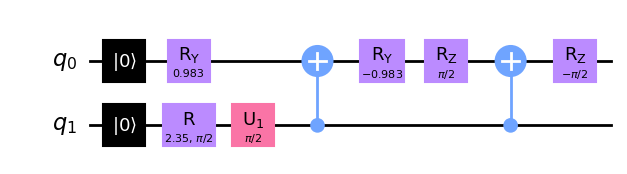

In [6]:
desired_state = [
    1 / math.sqrt(15.25) * 1.5,
    0,
    1 / math.sqrt(15.25) * -2,
    1 / math.sqrt(15.25) * 3]

qc = QuantumCircuit(2)
qc.initialize(desired_state, [0,1])

qc.decompose().decompose().decompose().decompose().decompose().draw(output="mpl")

## Arbitary Encoding

Arbitrary Kodierung kodiert N-Features als Rotationen auf N parametrisierten Gates auf n Qubits, wobei n<=N.<br>
Wie bei Angle Encoding, kodiert man hier nur jeweils einen Datenpunkt und nicht das ganze Dataset. Auch verwendet man einen PQC mit konstanter Tiefe und konstanter Anzahl an Qubits, dh. man kann es auf aktueller Quantenhardware durchführen.

# References

https://research-repository.griffith.edu.au/bitstream/handle/10072/21124/39875_1.pdf;sequence=1#:~:text=The%20original%20Meyer%2DWallach%20measure%20Q1%20is%20the%20average%20entanglement,increasing%20size%2C%20and%20the%20rest.
<br>
https://arxiv.org/pdf/1905.10876.pdf
<br>
https://link.springer.com/article/10.1007/s42484-021-00038-w
https://iopscience.iop.org/article/10.1088/1367-2630/ac37c8/pdf
<br>
https://learn.qiskit.org/course/machine-learning/

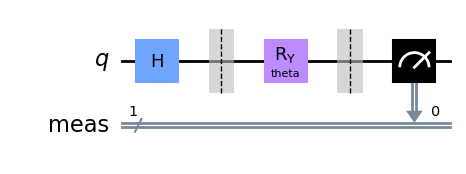

In [18]:
n_qubits = 1
shots = 100

circuit = QuantumCircuit(n_qubits)

all_qubits = [i for i in range(n_qubits)]
theta = Parameter('theta')

circuit.h(all_qubits)
circuit.barrier()
circuit.ry(theta, all_qubits)

circuit.measure_all()
circuit.draw(output="mpl")